In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import time

In [23]:
train_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
test_set = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()]),
)

In [24]:


# Initializing variables to store sum and squared sum
total_sum = 0
total_squared_sum = 0
num_pixels = 0

# Calculating mean and standard deviation
for data, _ in train_set:
    total_sum += data.sum()
    total_squared_sum += (data ** 2).sum()
    num_pixels += data.numel()

mean = total_sum / num_pixels
std_dev = (total_squared_sum / num_pixels - mean ** 2) ** 0.5

print(f"Mean: {mean.item()}")
print(f"Standard Deviation: {std_dev.item()}")


Mean: 0.2860410809516907
Standard Deviation: 0.3530237078666687


In [25]:


# Assuming these are the calculated mean and standard deviation values
mean_value = mean.item()  # replace with the calculated mean value
std_value = std_dev.item()  # replace with the calculated std deviation value

# Updated transformations with normalization
transforming_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_value,), (std_value,))
])

# Loading the FashionMNIST datasets with the updated transformations
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transforming_img)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transforming_img)


In [34]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10)

In [35]:
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }
    input = label.item() if type(label) == torch.Tensor else label
    return output_mapping[input]

In [36]:
a = next(iter(train_loader))
a[0].size()

torch.Size([10, 1, 28, 28])

In [37]:
len(train_set)

60000

9


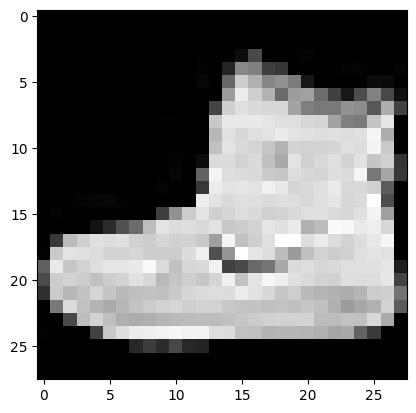

In [38]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [39]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


In [40]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


In [66]:

class AdjustedFashionCNN(nn.Module):
    def __init__(self, kernel_size=5):
        super(AdjustedFashionCNN, self).__init__()

        self.kernel_size = kernel_size
        input_size = 28
        
        output_channels1 = 32
        output_channels2 = 64

        # Compute output sizes after conv and pool operations
        conv1_out_size = input_size - self.kernel_size + 1
        pool1_out_size = conv1_out_size // 3  # Using kernel_size=3 for pooling

        conv2_input_size = pool1_out_size
        conv2_out_size = conv2_input_size - self.kernel_size + 1
        pool2_out_size = conv2_out_size // 3  # Using kernel_size=3 for pooling

        fc_input_size = output_channels2 * pool2_out_size * pool2_out_size

        # Conv Layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, output_channels1, kernel_size=self.kernel_size),
            nn.BatchNorm2d(output_channels1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(output_channels1, output_channels2, kernel_size=self.kernel_size),
            nn.BatchNorm2d(output_channels2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )

        # Fully Connected Layers
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(fc_input_size, 10)  # Set output size to 3 for classification
        self.softmax = nn.Softmax(dim=1)  # Softmax layer

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop(out)
        out = self.fc1(out)
        out = self.softmax(out)  # Apply softmax to get probabilities
        return out



# Create an instance of the adjusted model with a kernel size of 3 (for example) and print its architecture
adjusted_fashion_model = AdjustedFashionCNN(kernel_size=5)
adjusted_fashion_model

# Check if GPU is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adjusted_fashion_model.to(device)

AdjustedFashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Epoch [1/30], Train Accuracy: 74.88%, Test Accuracy: 80.73%, Train Loss: 1.7451, Test Loss: 1.6600
Epoch [2/30], Train Accuracy: 79.42%, Test Accuracy: 82.58%, Train Loss: 1.6776, Test Loss: 1.6408
Epoch [3/30], Train Accuracy: 81.69%, Test Accuracy: 84.69%, Train Loss: 1.6536, Test Loss: 1.6196
Epoch [4/30], Train Accuracy: 83.30%, Test Accuracy: 85.58%, Train Loss: 1.6360, Test Loss: 1.6084
Epoch [5/30], Train Accuracy: 84.07%, Test Accuracy: 85.75%, Train Loss: 1.6274, Test Loss: 1.6055
Epoch [6/30], Train Accuracy: 84.76%, Test Accuracy: 86.57%, Train Loss: 1.6194, Test Loss: 1.5978
Epoch [7/30], Train Accuracy: 85.10%, Test Accuracy: 86.78%, Train Loss: 1.6149, Test Loss: 1.5952
Epoch [8/30], Train Accuracy: 85.65%, Test Accuracy: 87.06%, Train Loss: 1.6094, Test Loss: 1.5928
Epoch [9/30], Train Accuracy: 85.93%, Test Accuracy: 87.56%, Train Loss: 1.6062, Test Loss: 1.5881
Epoch [10/30], Train Accuracy: 86.28%, Test Accuracy: 87.22%, Train Loss: 1.6029, Test Loss: 1.5902
Epoch [11

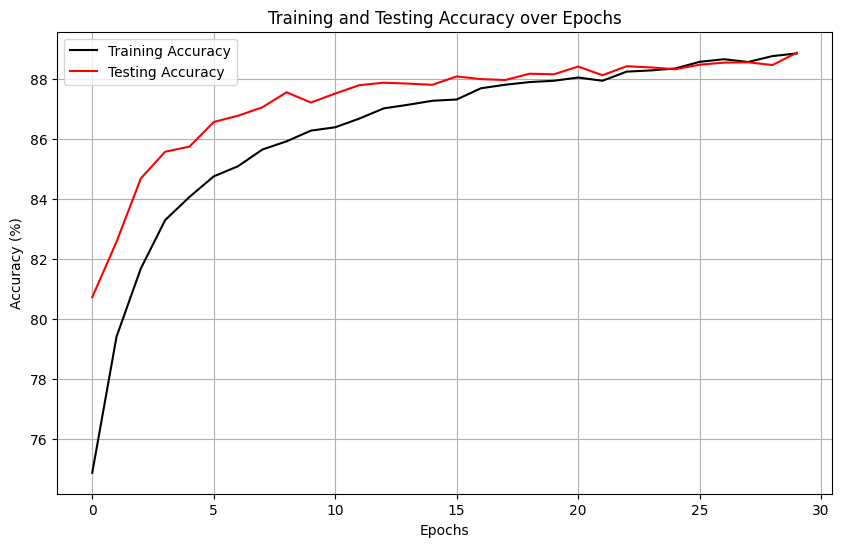

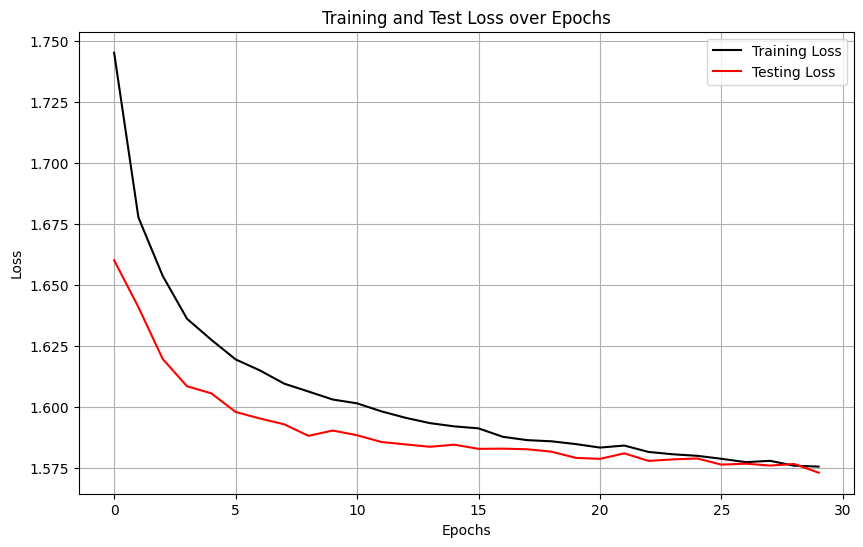

In [43]:
# Defining the train and test functions


def train(model, data_loader, criterion, optimizer):
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss


def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss


# Model, loss function, optimizer initialization
model = AdjustedFashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# Training the model and capturing metrics
num_epochs = 30
train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for epoch in range(num_epochs):
    train_accuracy, train_loss = train(model, train_loader, criterion, optimizer)
    test_accuracy, test_loss = test(model, test_loader)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}"
    )

print("Training and testing completed!")

# Visualizing the results
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, "k", label="Training Accuracy")
plt.plot(test_accuracies, "r", label="Testing Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_losses, "k", label="Training Loss")
plt.plot(test_losses, "r", label="Testing Loss")
plt.title("Training and Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [ ]:
# List of kernel sizes to experiment with
kernelSizes = [2, 3, 4, 5]

# Initialize lists to store the overall results for each kernel size
all_train_accuracies = {}
all_test_accuracies = {}
all_train_losses = {}
all_test_losses = {}

for kernel in kernelSizes:
    print(f"\nTraining with kernel size: {kernel}\n")
    # Model, loss function, optimizer initialization for current kernel size
    model = AdjustedFashionCNN(kernel_size=kernel).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

    # Lists to store metrics for the current kernel size
    train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

    for epoch in range(num_epochs):
        train_accuracy, train_loss = train(model, train_loader, criterion, optimizer)
        test_accuracy, test_loss = test(model, test_loader)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}"
        )

    # Store the results for the current kernel size
    all_train_accuracies[kernel] = train_accuracies
    all_test_accuracies[kernel] = test_accuracies
    all_train_losses[kernel] = train_losses
    all_test_losses[kernel] = test_losses

    print("Finished Training for kernel size:", kernel)

# Visualizing the results for all kernel sizes
plt.figure(figsize=(10, 6))
for kernel, acc in all_train_accuracies.items():
    plt.plot(acc, label=f"Training Accuracy (Kernel {kernel})")
for kernel, acc in all_test_accuracies.items():
    plt.plot(acc, "--", label=f"Testing Accuracy (Kernel {kernel})")

plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for kernel, loss in all_train_losses.items():
    plt.plot(loss, label=f"Training Loss (Kernel {kernel})")
for kernel, loss in all_test_losses.items():
    plt.plot(loss, "--", label=f"Testing Loss (Kernel {kernel})")

plt.title("Training and Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

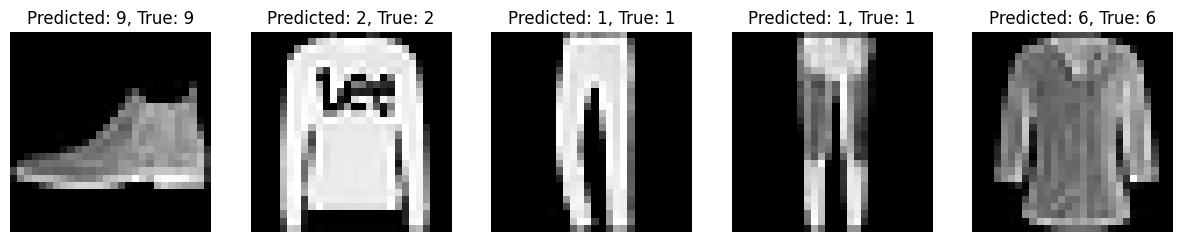

In [ ]:
# Function to predict and plot
def predict_and_plot(model, data_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure(figsize=(15, 7))

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 5, 5, images_so_far)
                ax.axis("off")
                ax.set_title(f"Predicted: {preds[j]}, True: {labels[j]}")
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                plt.imshow(img.squeeze(), cmap="gray")

                if images_so_far == num_images:
                    return


# Predict and plot using the test data
predict_and_plot(model, test_loader)

In [73]:

class AdjustedFashionCNN(nn.Module):
    def __init__(
        self, input_size=28 ,kernel_size=5, num_filters1=32, num_filters2=64, dropout_rate=0.5, in_channels = 1,
    classes = 10):
        super(AdjustedFashionCNN, self).__init__()

        self.kernel_size = kernel_size
        self.input_size = input_size

        # Compute output sizes after conv and pool operations
        conv1_out_size = self.input_size - self.kernel_size + 1
        pool1_out_size = (
            conv1_out_size // 3
        )  # Using kernel_size=2 and stride=2 for pooling

        conv2_input_size = pool1_out_size
        conv2_out_size = conv2_input_size - self.kernel_size + 1
        pool2_out_size = conv2_out_size // 3

        fc_input_size = num_filters2 * pool2_out_size * pool2_out_size

        # Layer 2 to 5
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=num_filters1,
                kernel_size=self.kernel_size,
            ),  # Layer 2: Convolutional layer
            nn.BatchNorm2d(num_filters1),  # Layer 3: Batch normalization
            nn.ReLU(),  # Layer 4: ReLU activation
            nn.MaxPool2d(kernel_size=3, stride=3),  # Layer 5: Max Pooling
        )

        # Layer 6 to 9
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_filters1,
                out_channels=num_filters2,
                kernel_size=self.kernel_size,
            ),  # Layer 6: Convolutional layer
            nn.BatchNorm2d(num_filters2),  # Layer 7: Batch normalization
            nn.ReLU(),  # Layer 8: ReLU activation
            nn.MaxPool2d(kernel_size=3, stride=3),  # Layer 9: Max Pooling
        )
        self.drop = nn.Dropout2d(dropout_rate)
        # Fully Connected Layers
        self.fc1 = nn.Linear(fc_input_size, classes)  # Set output size to 3 for classification
        self.softmax = nn.Softmax(dim=1)  # Softmax layer

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop(out)
        out = self.fc1(out)
        out = self.softmax(out)  # Apply softmax to get probabilities
        return out


# For testing purposes:
# Create an instance of the adjusted model with a kernel size of 3 and filter numbers of 32 and 64 respectively.
# Print its architecture.
adjusted_fashion_model = AdjustedFashionCNN(
    kernel_size=3, num_filters1=32, num_filters2=64
)
print(adjusted_fashion_model)

AdjustedFashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
import time

# Define hyperparameters to tune
learning_rates = [0.0001, 0.00001,0.000001 ]
batch_sizes = [32, 64, 128]
optimizers = [torch.optim.SGD, torch.optim.Adam]
dropout_rates = [0.2, 0.5]
kernel_sizes = [2, 3, 4, 5, 6]
num_epochs = 5

best_accuracy = 0.0
best_params = {}

results = {}  # Dictionary to store results

# Counter to keep track of configurations
config_count = 1
total_configs = (
    len(learning_rates)
    * len(batch_sizes)
    * len(optimizers)
    * len(dropout_rates)
    * len(kernel_sizes)
)
# Grid search
for lr in learning_rates:
    for bs in batch_sizes:
        for opt in optimizers:
            for dr in dropout_rates:
                for ks in kernel_sizes:
                    config_key = f"LR: {lr}, BS: {bs}, Optimizer: {opt.__name__}, Dropout: {dr}, Kernel: {ks}"
                    print(f"Configuration {config_count}/{total_configs}:")
                    print(config_key)

                    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs)
                    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs)

                    model = AdjustedFashionCNN(kernel_size=ks, dropout_rate=dr).to(
                        device
                    )
                    criterion = nn.CrossEntropyLoss()
                    optimizer = opt(model.parameters(), lr=lr)

                    # Variables to store cumulative loss across epochs
                    total_train_loss = 0.0
                    total_test_loss = 0.0
                    start_time = time.time()

                    # Train and test the model with the current hyperparameters for the specified number of epochs
                    for epoch in range(num_epochs):
                        train_accuracy, train_loss = train(
                            model, train_loader, criterion, optimizer
                        )
                        total_train_loss += train_loss

                        # Skip further training and testing for this configuration if training accuracy is less than 80%
                        if train_accuracy < 80.0:
                            print(
                                "Train accuracy is less than 80%. Skipping this configuration."
                            )
                            break

                        test_accuracy, test_loss = test(model, test_loader)
                        total_test_loss += test_loss

                        # Printing per-epoch results
                        print(f"Epoch {epoch+1}/{num_epochs}:")
                        print(
                            f"Train Accuracy: {train_accuracy:.2f}% - Train Loss: {train_loss:.4f}"
                        )
                        print(
                            f"Test Accuracy: {test_accuracy:.2f}% - Test Loss: {test_loss:.4f}"
                        )
                        print("----------------------------------------")

                    avg_train_loss = total_train_loss / num_epochs
                    avg_test_loss = total_test_loss / num_epochs
                    end_time = time.time()
                    config_time = end_time - start_time

                    # Store the results ONLY if train_accuracy >= 80%
                    if train_accuracy >= 80.0:
                        results[config_key] = {
                            "Train Accuracy": train_accuracy,
                            "Test Accuracy": test_accuracy,
                            "Average Train Loss": avg_train_loss,
                            "Average Test Loss": avg_test_loss,
                            "Time (in sec)": config_time
                        }

                    # Update best accuracy and parameters
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = {
                            "lr": lr,
                            "batch_size": bs,
                            "optimizer": opt,
                            "dropout_rate": dr,
                            "kernel_size": ks,
                        }
                    print("------------------------------------------------------")
                    config_count += 1

print("Best Test Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)

Configuration 1/144:
LR: 0.1, BS: 32, Optimizer: SGD, Dropout: 0.2, Kernel: 2
Epoch 1/5:
Train Accuracy: 82.48% - Train Loss: 0.4945
Test Accuracy: 82.82% - Test Loss: 0.4577
----------------------------------------
Epoch 2/5:
Train Accuracy: 88.59% - Train Loss: 0.3198
Test Accuracy: 88.66% - Test Loss: 0.3154
----------------------------------------
Epoch 3/5:
Train Accuracy: 89.86% - Train Loss: 0.2787
Test Accuracy: 89.30% - Test Loss: 0.3063
----------------------------------------
Epoch 4/5:
Train Accuracy: 90.64% - Train Loss: 0.2555
Test Accuracy: 89.96% - Test Loss: 0.2876
----------------------------------------
Epoch 5/5:
Train Accuracy: 91.31% - Train Loss: 0.2382
Test Accuracy: 89.95% - Test Loss: 0.2945
----------------------------------------
------------------------------------------------------
Configuration 2/144:
LR: 0.1, BS: 32, Optimizer: SGD, Dropout: 0.2, Kernel: 3
Epoch 1/5:
Train Accuracy: 83.07% - Train Loss: 0.4703
Test Accuracy: 85.36% - Test Loss: 0.4053
--

In [ ]:


# Convert the results dictionary to a DataFrame
df_results = pd.DataFrame.from_dict(results, orient="index")

# Save the DataFrame to a CSV file
df_results.to_csv("./data/results.csv")

print("Results saved to 'results.csv'")

Results saved to 'results.csv'


In [ ]:
# run their parameters in the fashion and get the results -- 97.2%
# run the different parameters in the fashion data and get the best combinations .... Arend claimed low Kernel size will be better
# take the best hyperparameter and run it on the MRI data set and then compare
# check if hyper-tuning on small dataset can be faster/better/works and if our claim would be correct and generalize it to larger dataset
# then check if we get better results than the MRI paper

In [57]:
import pathlib

In [49]:
train_path = ('./data/Training/')
test_path = ('./data/Testing/')
train_set = torchvision.datasets.ImageFolder(train_path,transform=transforming_img)
test_set= torchvision.datasets.ImageFolder(test_path,transform=transforming_img)


In [50]:


# Initializing variables to store sum and squared sum
total_sum = 0
total_squared_sum = 0
num_pixels = 0

# Calculating mean and standard deviation
for data, _ in train_set:
    total_sum += data.sum()
    total_squared_sum += (data ** 2).sum()
    num_pixels += data.numel()

mean = total_sum / num_pixels
std_dev = (total_squared_sum / num_pixels - mean ** 2) ** 0.5

print(f"Mean: {mean.item()}")
print(f"Standard Deviation: {std_dev.item()}")


Mean: -0.6412369608879089
Standard Deviation: 0.3737756311893463


In [58]:


# Assuming these are the calculated mean and standard deviation values
mean_value = mean.item()  # replace with the calculated mean value
std_value = std_dev.item()  # replace with the calculated std deviation value

# Updated transformations with normalization
transforming_img = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((mean_value,), (std_value,))
])

# Loading the FashionMNIST datasets with the updated transformations
train_set = torchvision.datasets.ImageFolder(train_path,transform=transforming_img)
test_set= torchvision.datasets.ImageFolder(test_path,transform=transforming_img)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10)

In [59]:
print(f'The classes are: {classes}')


The classes are: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [75]:
unique_labels = set()
for _, labels in train_loader:
    unique_labels.update(labels.numpy())

print(unique_labels)


{0, 1, 2, 3}


In [60]:
import glob

In [61]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [76]:
# Defining the train and test functions
def train(model, data_loader, criterion, optimizer):
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss


def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss


# Model, loss function, optimizer initialization
model = AdjustedFashionCNN(input_size=227,in_channels=3, classes = 4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# Training the model and capturing metrics
num_epochs = 30
train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for epoch in range(num_epochs):
    train_accuracy, train_loss = train(model, train_loader, criterion, optimizer)
    test_accuracy, test_loss = test(model, test_loader)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}"
    )

print("Training and testing completed!")

# Visualizing the results
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, "k", label="Training Accuracy")
plt.plot(test_accuracies, "r", label="Testing Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_losses, "k", label="Training Loss")
plt.plot(test_losses, "r", label="Testing Loss")
plt.title("Training and Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

Epoch [1/30], Train Accuracy: 28.47%, Test Accuracy: 25.38%, Train Loss: 1.4587, Test Loss: 1.4937
Epoch [2/30], Train Accuracy: 28.78%, Test Accuracy: 25.38%, Train Loss: 1.4559, Test Loss: 1.4937


In [ ]:
# Define hyperparameters to tune
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_sizes = [32, 64, 128]
optimizers = [torch.optim.SGD, torch.optim.Adam]
dropout_rates = [0.2, 0.5]
kernel_sizes = [2, 3, 4, 5, 6]
num_epochs = 30

best_accuracy = 0.0
best_params = {}

results = {}  # Dictionary to store results

# Counter to keep track of configurations
config_count = 1
total_configs = (
    len(learning_rates)
    * len(batch_sizes)
    * len(optimizers)
    * len(dropout_rates)
    * len(kernel_sizes)
)
# Grid search
for lr in learning_rates:
    for bs in batch_sizes:
        for opt in optimizers:
            for dr in dropout_rates:
                for ks in kernel_sizes:
                    config_key = f"LR: {lr}, BS: {bs}, Optimizer: {opt.__name__}, Dropout: {dr}, Kernel: {ks}"
                    print(f"Configuration {config_count}/{total_configs}:")
                    print(config_key)

                    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs)
                    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs)

                    model = AdjustedFashionCNN(kernel_size=ks, dropout_rate=dr).to(
                        device
                    )
                    criterion = nn.CrossEntropyLoss()
                    optimizer = opt(model.parameters(), lr=lr)

                    # Variables to store cumulative loss across epochs
                    total_train_loss = 0.0
                    total_test_loss = 0.0

                    # Train and test the model with the current hyperparameters for the specified number of epochs
                    for epoch in range(num_epochs):
                        train_accuracy, train_loss = train(
                            model, train_loader, criterion, optimizer
                        )
                        total_train_loss += train_loss

                        # Skip further training and testing for this configuration if training accuracy is less than 80%
                        if train_accuracy < 80.0:
                            print(
                                "Train accuracy is less than 80%. Skipping this configuration."
                            )
                            break

                        test_accuracy, test_loss = test(model, test_loader)
                        total_test_loss += test_loss

                        # Printing per-epoch results
                        print(f"Epoch {epoch+1}/{num_epochs}:")
                        print(
                            f"Train Accuracy: {train_accuracy:.2f}% - Train Loss: {train_loss:.4f}"
                        )
                        print(
                            f"Test Accuracy: {test_accuracy:.2f}% - Test Loss: {test_loss:.4f}"
                        )
                        print("----------------------------------------")

                    avg_train_loss = total_train_loss / num_epochs
                    avg_test_loss = total_test_loss / num_epochs

                    # Store the results ONLY if train_accuracy >= 80%
                    if train_accuracy >= 80.0:
                        results[config_key] = {
                            "Train Accuracy": train_accuracy,
                            "Test Accuracy": test_accuracy,
                            "Average Train Loss": avg_train_loss,
                            "Average Test Loss": avg_test_loss,
                        }

                    # Update best accuracy and parameters
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = {
                            "lr": lr,
                            "batch_size": bs,
                            "optimizer": opt,
                            "dropout_rate": dr,
                            "kernel_size": ks,
                        }
                    print("------------------------------------------------------")
                    config_count += 1

print("Best Test Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)